In [2]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import *
from cVAE_utils import *
from cVAE_trainer import *

/afs/inf.ed.ac.uk/user/s24/s2442138/miniconda3/envs/ConGele/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/afs/inf.ed.ac.uk/user/s24/s2442138/miniconda3/envs/ConGele/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/afs/inf.ed.ac.uk/user

# RAE-ALL-1_1_0.01-10

In [3]:
alpha=250000
beta=1
gamma=0.01

In [4]:
state_dict_path = "3DcVAE_asd-UKBB604-dim32/3-RAE-ALL-train_480-val_120-HP-alpha_250000-beta_1-gamma_0.01-batch_size_10/model_final.pth"
state_dict = torch.load(state_dict_path)       

In [5]:
train_history = state_dict["train_info_history"]
val_history = state_dict["val_info_history"]

print(state_dict.keys())
print(train_history.keys())
print(val_history.keys())

dict_keys(['model', 'optimizer', 'epoch', 'best_loss', 'bad_epochs', 'val_info_history', 'train_info_history'])
dict_keys(['reconst_loss_tg', 'reconst_loss_bg', 'reconst_loss', 'KL_s_tg', 'KL_z_tg', 'KL_z_bg', 'KL_loss', 'TC_loss', 'discriminator_loss', 'loss', 'v_acc', 'v_bar_acc', 'v_score_mean', 'v_bar_score_mean'])
dict_keys(['reconst_loss_tg', 'reconst_loss_bg', 'reconst_loss', 'KL_s_tg', 'KL_z_tg', 'KL_z_bg', 'KL_loss', 'TC_loss', 'discriminator_loss', 'loss', 'ss', 'ss-plot', 'v_acc', 'v_bar_acc', 'v_score_mean', 'v_bar_score_mean'])


## train/val loss + ss

In [51]:
loss_train = train_history["loss"]
loss_val = val_history["loss"]
ss_plot = val_history["ss"]
epochs = np.arange(0, len(loss_train)) 

print(len(loss_train))
print(len(loss_val))
print(len(ss_plot))
print(len(epochs))

print(loss_train[:10])
print(loss_val[:10])
print(ss_plot[:10])
print(epochs[:10])
print()

print(ss_plot[239])

247
247
247
247
[94686840619008.0, 358619.5625, 210793.65625, 177688.53125, 147615.859375, 126703.21875, 114704.640625, 104500.375, 98936.7421875, 89799.75]
[682645.25, 243869.84375, 208803.78125, 165407.015625, 129727.0, 122772.453125, 115445.0234375, 101703.890625, 98080.859375, 87412.953125]
[-0.032045666, -0.034707148, -0.036214642, -0.03744457, -0.03798886, -0.0389666, -0.040358998, -0.040928412, -0.04131872, -0.040920492]
[0 1 2 3 4 5 6 7 8 9]

-0.020679537


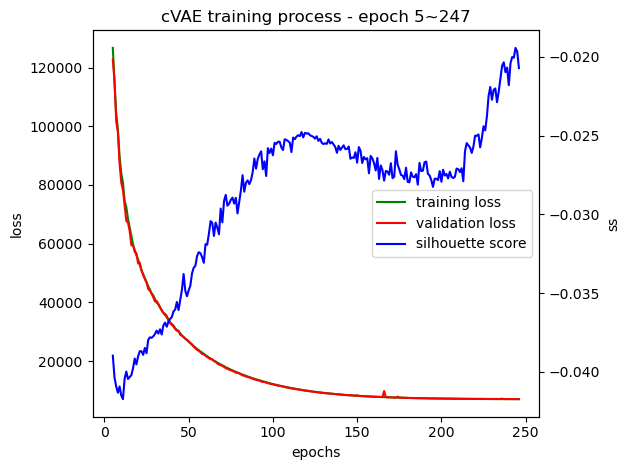

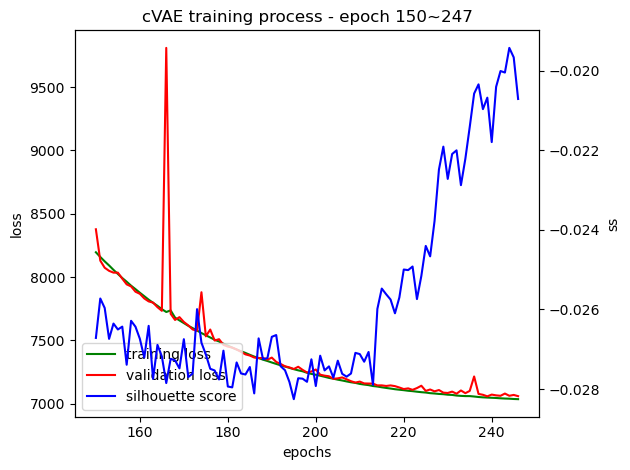

In [7]:
## ---------------------------------------------------------------
left = 5
right = len(epochs)

fig, ax1 = plt.subplots()
lns1 = ax1.plot(epochs[left:right], loss_train[left:right], label='training loss', color='g')
lns2 = ax1.plot(epochs[left:right], loss_val[left:right], label='validation loss', color='r')
ax1.set_ylabel('loss')
ax1.set_xlabel('epochs')
#ax1.legend()

ax2 = ax1.twinx()
lns3 = ax2.plot(epochs[left:right], ss_plot[left:right], label='silhouette score', color='b')
ax2.set_ylabel('ss')
#ax2.legend(loc='upper left')

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=7)

plt.title(f'cVAE training process - epoch {left}~{right}')
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()
plt.show()

## ---------------------------------------------------------------
left = 150
right = len(epochs)

fig, ax1 = plt.subplots()
lns1 = ax1.plot(epochs[left:right], loss_train[left:right], label='training loss', color='g')
lns2 = ax1.plot(epochs[left:right], loss_val[left:right], label='validation loss', color='r')
ax1.set_ylabel('loss')
ax1.set_xlabel('epochs')
#ax1.legend()

ax2 = ax1.twinx()
lns3 = ax2.plot(epochs[left:right], ss_plot[left:right], label='silhouette score', color='b')
ax2.set_ylabel('ss')
#ax2.legend(loc='upper left')

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=3)

plt.title(f'cVAE training process - epoch {left}~{right}')
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()
plt.show()

## train/val

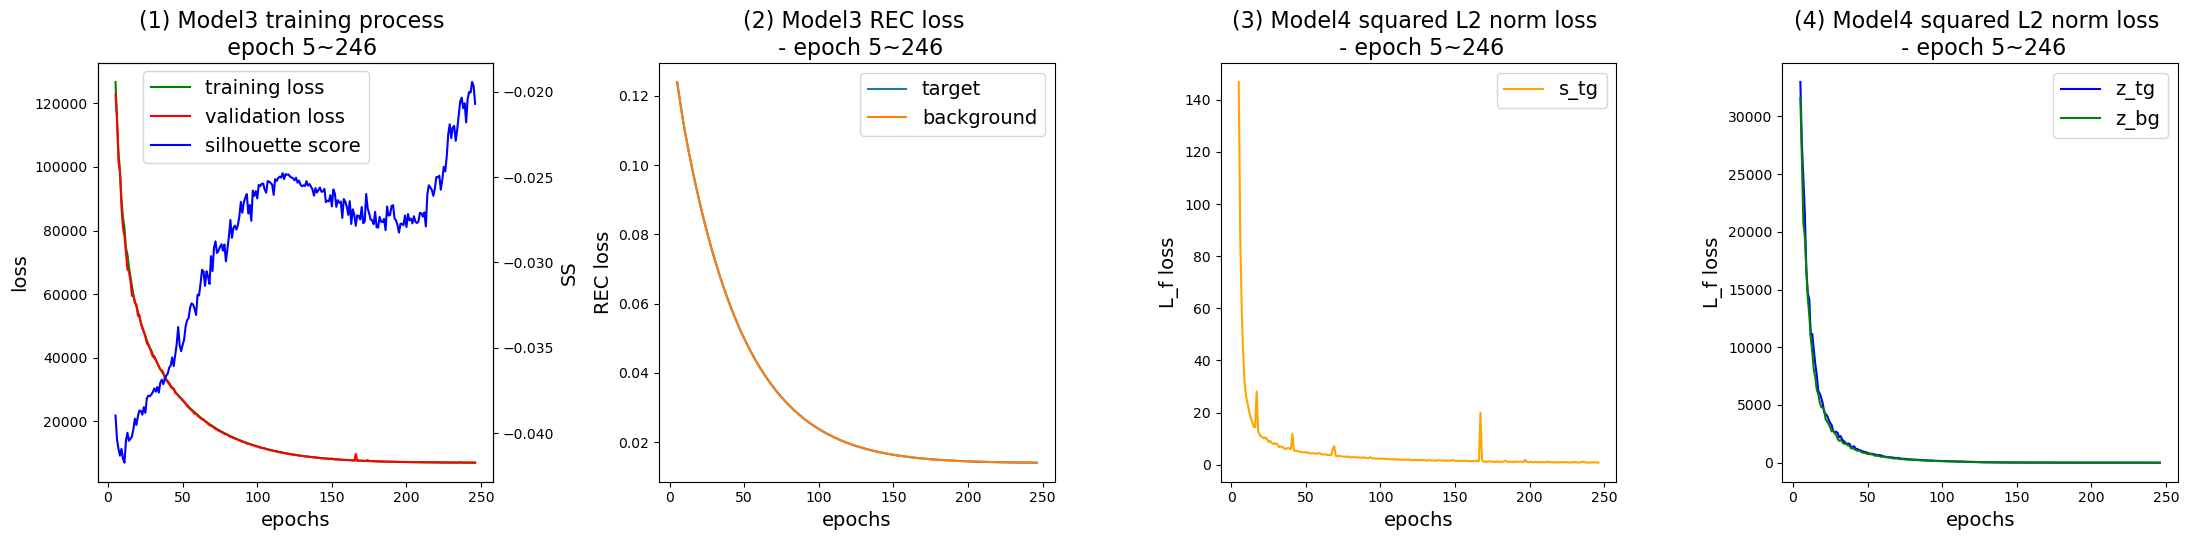

In [43]:
fig, (ax1,ax5, ax2,ax3) = plt.subplots(1,4,figsize=(22,5.5))
title_size = 16
label_size = 14
legend_size = 14

left = 5
right = len(epochs)
lns1 = ax1.plot(epochs[left:right], loss_train[left:right], label='training loss', color='g')
lns2 = ax1.plot(epochs[left:right], loss_val[left:right], label='validation loss', color='r')
ax1.set_ylabel('loss', fontsize=label_size)
ax1.set_xlabel('epochs', fontsize=label_size)
ax4 = ax1.twinx()
lns3 = ax4.plot(epochs[left:right], ss_plot[left:right], label='silhouette score', color='b')
ax4.set_ylabel('SS', fontsize=label_size)
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=legend_size, loc="center", bbox_to_anchor=(0.4, 0.87))
plt.title(f'(1) Model3 training process \n  epoch {left}~{right-1}', fontsize=title_size)

left = 5
right = len(epochs)
ax5.plot(epochs[left:right], np.array(train_history["reconst_loss_tg"])[left:right]  / (160 * 192 * 160), label=f'target')
ax5.plot(epochs[left:right], np.array(train_history["reconst_loss_bg"])[left:right]  / (160 * 192 * 160), label=f'background')
ax5.set_title(f'(2) Model3 REC loss \n - epoch {left}~{right-1}', fontsize=title_size)
ax5.set_xlabel("epochs", fontsize=label_size)
ax5.set_ylabel("REC loss", fontsize=label_size)
ax5.legend(fontsize=legend_size)

left = 5
right = len(epochs)
ax2.plot(epochs[left:right], np.array(train_history["KL_s_tg"])[left:right], label=f's_tg', color='orange')
# ax2.plot(epochs[left:right], np.array(train_history["KL_z_tg"])[left:right], label=f'z_tg', color='blue')
# ax2.plot(epochs[left:right], np.array(train_history["KL_z_bg"])[left:right], label=f'z_bg', color='green')
ax2.set_ylabel('L_f loss', fontsize=label_size)
ax2.set_xlabel('epochs', fontsize=label_size)
ax2.legend(fontsize=legend_size)
ax2.set_title(f'(3) Model4 squared L2 norm loss \n - epoch {left}~{right-1}', fontsize=title_size)

left = 5
right = len(epochs)
# ax3.plot(epochs[left:right], np.array(train_history["KL_s_tg"])[left:right], label=f's_tg', color='orange')
ax3.plot(epochs[left:right], np.array(train_history["KL_z_tg"])[left:right], label=f'z_tg', color='blue')
ax3.plot(epochs[left:right], np.array(train_history["KL_z_bg"])[left:right], label=f'z_bg', color='green')
ax3.set_ylabel('L_f loss', fontsize=label_size)
ax3.set_xlabel('epochs', fontsize=label_size)
ax3.legend(fontsize=legend_size)
ax3.set_title(f'(4) Model4 squared L2 norm loss \n - epoch {left}~{right-1}', fontsize=title_size)

fig.tight_layout()
plt.savefig("./analysis/Model4-loss.png")
plt.show()

In [45]:
np.array(train_history["KL_s_tg"])[5]

146.82156372070312

In [46]:
np.array(train_history["KL_s_tg"])[50]

4.752695083618164

## Train loss

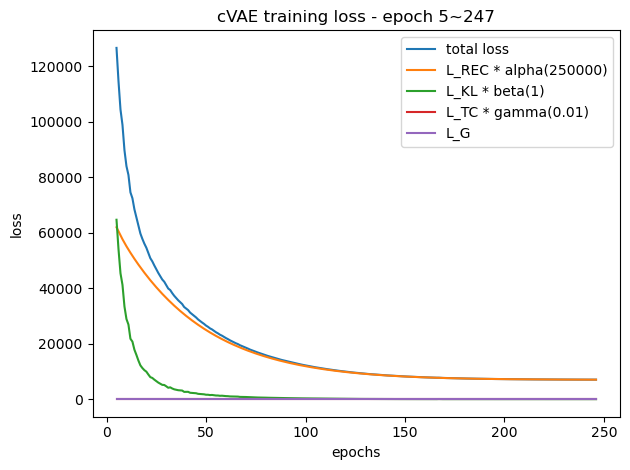

In [9]:
# alpha=1
# beta=1
# gamma=0.01

left = 5
right = len(epochs)

## 'loss'
plt.plot(epochs[left:right], train_history["loss"][left:right] , label='total loss')

## "reconst_loss", alpha=250000
## 'reconst_loss_tg', 'reconst_loss_bg'
# plt.plot(epochs[left:right], np.array(train_history["reconst_loss"])[left:right] / (160 * 192 * 160) , label='reconst_train')
plt.plot(epochs[left:right], alpha * np.array(train_history["reconst_loss"])[left:right]  / (160 * 192 * 160), label=f'L_REC * alpha({alpha})')

## "KL_loss", beta = 1
## 'KL_s_tg', 'KL_z_tg', 'KL_z_bg'
plt.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'L_KL * beta({beta})')
# plt.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label='beta * KL_s_tg')
# plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label='beta * KL_z_tg')
# plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label='beta * KL_z_bg')

## 'TC_loss', gamma=100
# plt.plot(epochs[left:right], np.array(train_history["TC_loss"])[left:right], label='TC_train')
plt.plot(epochs[left:right], gamma * np.array(train_history["TC_loss"])[left:right], label=f'L_TC * gamma({gamma})')

## 'discriminator_loss'
plt.plot(epochs[left:right], np.array(train_history["discriminator_loss"])[left:right], label='L_G')

plt.title(f'cVAE training loss - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

## Train REC loss

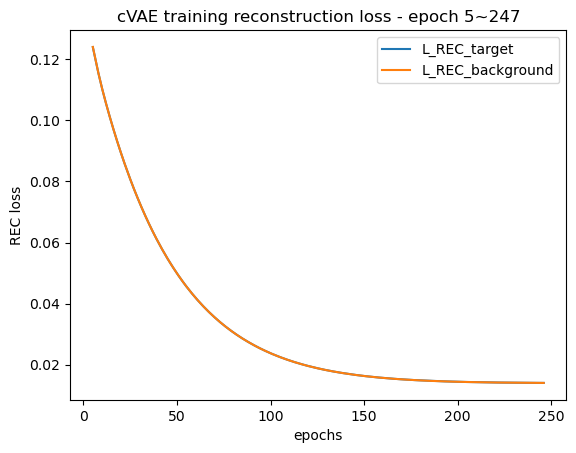

In [10]:
## "reconst_loss", alpha=1
## 'reconst_loss_tg', 'reconst_loss_bg'

## ---------------------------------------------------------------
left = 5
right = len(epochs)

#plt.plot(epochs[left:right], np.array(train_history["reconst_loss"])[left:right]  / (160 * 192 * 160), label=f'L_REC')
plt.plot(epochs[left:right], np.array(train_history["reconst_loss_tg"])[left:right]  / (160 * 192 * 160), label=f'L_REC_target')
plt.plot(epochs[left:right], np.array(train_history["reconst_loss_bg"])[left:right]  / (160 * 192 * 160), label=f'L_REC_background')

plt.title(f'cVAE training reconstruction loss - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("REC loss")
plt.legend()

fig.tight_layout()
plt.show()

## ---------------------------------------------------------------
# left = 175
# right = 200

# #plt.plot(epochs[left:right], np.array(train_history["reconst_loss"])[left:right]  / (160 * 192 * 160), label=f'L_REC')
# plt.plot(epochs[left:right], np.array(train_history["reconst_loss_tg"])[left:right]  / (160 * 192 * 160), label=f'L_REC_target')
# plt.plot(epochs[left:right], np.array(train_history["reconst_loss_bg"])[left:right]  / (160 * 192 * 160), label=f'L_REC_background')

# plt.title(f'cVAE training reconstruction loss - epoch {left}~{right}')
# plt.xlabel("epochs")
# plt.ylabel("REC loss")
# plt.legend()

# fig.tight_layout()
# plt.show()

In [11]:
print(np.array(train_history["reconst_loss_tg"])[0] /  (160 * 192 * 160))
print(np.array(train_history["reconst_loss_tg"])[-1] /  (160 * 192 * 160))

0.1505656305948893
0.014063803354899089


## Train KL loss

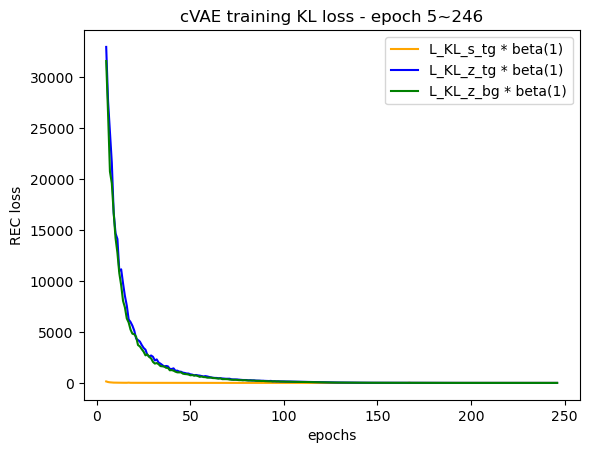

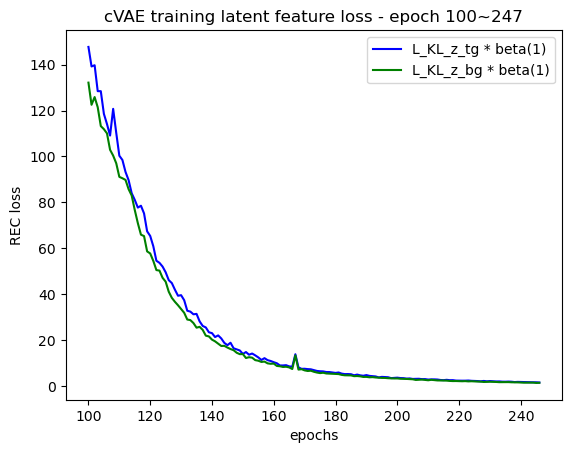

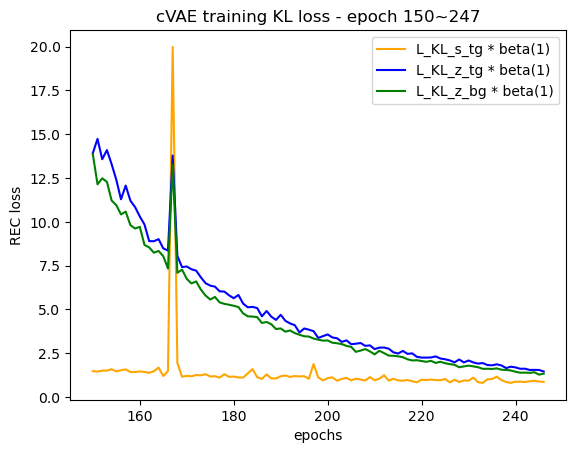

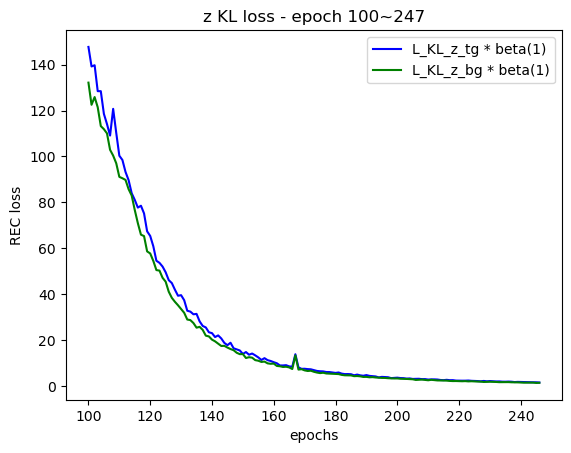

In [47]:
## "KL_loss", beta = 1
## 'KL_s_tg', 'KL_z_tg', 'KL_z_bg'

## ---------------------------------------------------------------
left = 5
right = len(epochs)

# plt.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'0.5 * L2 squre norm * beta({beta})')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label=f'L_KL_s_tg * beta({beta})', color='orange')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label=f'L_KL_z_tg * beta({beta})', color='blue')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label=f'L_KL_z_bg * beta({beta})', color='green')

plt.title(f'cVAE training KL loss - epoch {left}~{right-1}')
plt.xlabel("epochs")
plt.ylabel("REC loss")
plt.legend()

fig.tight_layout()
plt.show()

## ---------------------------------------------------------------
left = 100
right = len(epochs)

# plt.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'0.5 * L2 squre norm * beta({beta})')
# plt.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label=f'L_KL_s_tg * beta({beta})', color='orange')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label=f'L_KL_z_tg * beta({beta})', color='blue')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label=f'L_KL_z_bg * beta({beta})', color='green')

plt.title(f'cVAE training latent feature loss - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("REC loss")
plt.legend()

fig.tight_layout()
plt.show()

## ---------------------------------------------------------------
left = 150
right = len(epochs)
plt.title(f'cVAE training KL loss - epoch {left}~{right}')

# plt.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'L_KL * beta({beta})')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label=f'L_KL_s_tg * beta({beta})', color='orange')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label=f'L_KL_z_tg * beta({beta})', color='blue')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label=f'L_KL_z_bg * beta({beta})', color='green')

plt.xlabel("epochs")
plt.ylabel("REC loss")
plt.legend()

fig.tight_layout()
plt.show()

## ---------------------------------------------------------------
left = 100
right = len(epochs)
plt.title(f'z KL loss - epoch {left}~{right}')

# plt.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'L_KL * beta({beta})')
# plt.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label=f'L_KL_s_tg * beta({beta})', color='orange')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label=f'L_KL_z_tg * beta({beta})', color='blue')
plt.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label=f'L_KL_z_bg * beta({beta})', color='green')

plt.xlabel("epochs")
plt.ylabel("REC loss")
plt.legend()

fig.tight_layout()
plt.show()



In [39]:
np.array(train_history["KL_s_tg"])[200]

1.0790903568267822

In [48]:
((np.array(train_history["KL_z_tg"])+np.array(train_history["KL_z_bg"])) / 2)[5]

32283.578125

In [49]:
((np.array(train_history["KL_z_tg"])+np.array(train_history["KL_z_bg"])) / 2)[-1]

1.3931668400764465

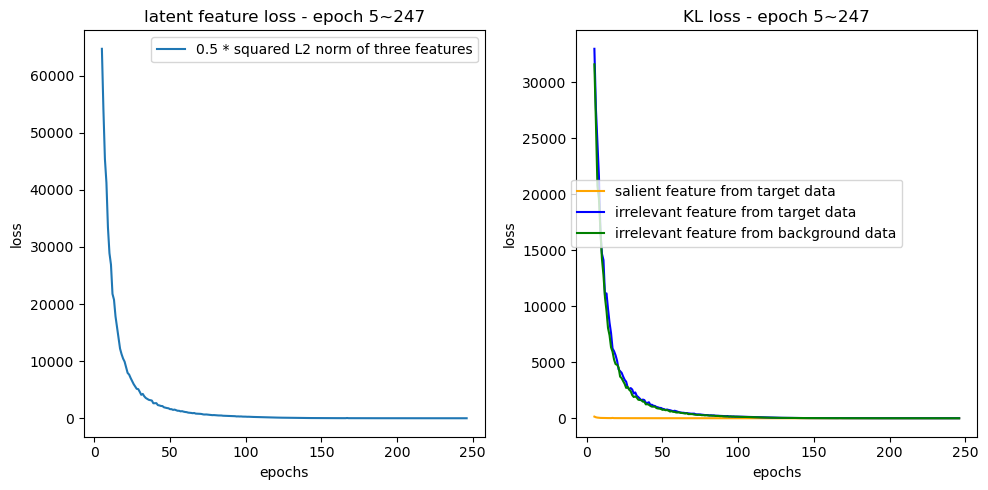

In [13]:
fig, (ax2, ax1) = plt.subplots(1,2,figsize=(10, 5))

left = 5
right = len(epochs)
ax1.set_title(f'KL loss - epoch {left}~{right}')
ax1.plot(epochs[left:right], beta * np.array(train_history["KL_s_tg"])[left:right], label=f'salient feature from target data', color='orange')
ax1.plot(epochs[left:right], beta * np.array(train_history["KL_z_tg"])[left:right], label=f'irrelevant feature from target data', color='blue')
ax1.plot(epochs[left:right], beta * np.array(train_history["KL_z_bg"])[left:right], label=f'irrelevant feature from background data', color='green')
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend(loc="center",  bbox_to_anchor=(0.4, 0.55))

left = 5
right = len(epochs)
ax2.set_title(f'latent feature loss - epoch {left}~{right}')
ax2.plot(epochs[left:right], beta * np.array(train_history["KL_loss"])[left:right], label=f'0.5 * squared L2 norm of three features')
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend()

fig.tight_layout()
plt.savefig("./teams/L2-loss.png")
plt.show()

In [14]:
print(np.array(train_history["KL_s_tg"])[150:200])

[ 1.4766705   1.45193374  1.50514543  1.50595832  1.58763731  1.45896864
  1.52842927  1.57931828  1.42561436  1.42510438  1.46352506  1.42835355
  1.38141763  1.47082138  1.68076515  1.19871974  1.48059893 19.98428154
  1.93661785  1.1613543   1.20636415  1.18247414  1.25726223  1.23856187
  1.30461049  1.17028224  1.19044518  1.10442829  1.3042655   1.15081024
  1.16804695  1.11614084  1.11006153  1.35042882  1.59644544  1.12997913
  1.03361642  1.29057133  1.06407225  1.05903506  1.18567419  1.22726798
  1.14593887  1.1972208   1.1764344   1.1875788   1.04364586  1.8810935
  1.11807477  0.95083827]


## Train TC + G loss

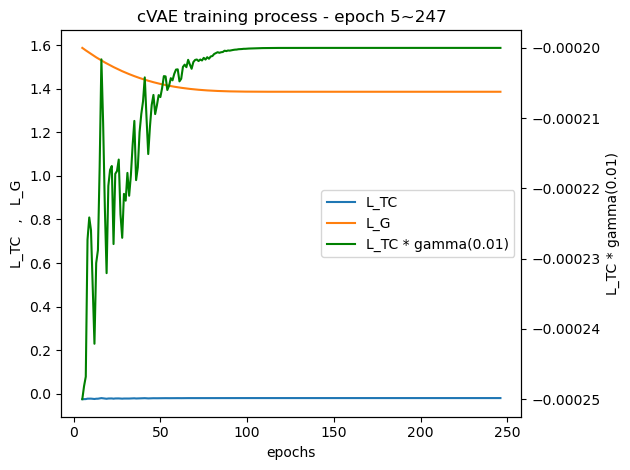

In [15]:
## 'TC_loss', gamma=1
## 'discriminator_loss'

## ---------------------------------------------------------------
left = 5
right = len(epochs)

fig, ax1 = plt.subplots()
lns1 = ax1.plot(epochs[left:right], np.array(train_history["TC_loss"])[left:right], label='L_TC')
lns2 = ax1.plot(epochs[left:right], np.array(train_history["discriminator_loss"])[left:right], label='L_G')
ax1.set_xlabel('epochs')
ax1.set_ylabel(f'L_TC   ,   L_G')

ax2 = ax1.twinx()
lns3 = ax2.plot(epochs[left:right], gamma * np.array(train_history["TC_loss"])[left:right], label=f'L_TC * gamma({gamma})', color='g')
ax2.set_ylabel(f'L_TC * gamma({gamma})')

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.title(f'cVAE training process - epoch {left}~{right}')
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()
plt.show()

In [16]:
print(train_history["discriminator_loss"][0])
print(train_history["TC_loss"][0])

1.6176704168319702
-0.004452298395335674


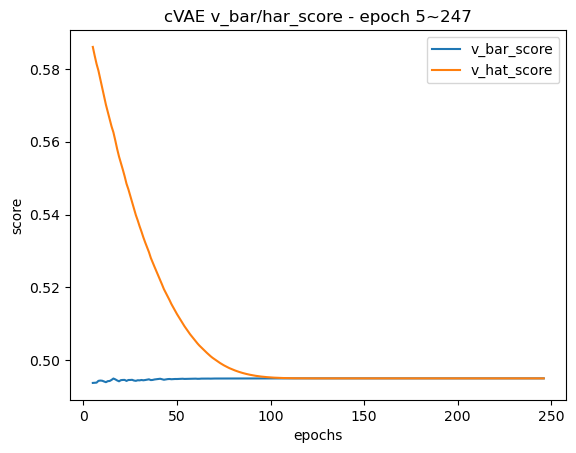

In [17]:
v_bar_score = np.exp(np.array(train_history["TC_loss"])) / (1 + np.exp(np.array(train_history["TC_loss"])))
v_hat_score = 1 - ( np.exp(-1 * np.array(train_history["discriminator_loss"])) / v_bar_score ) 

## ---------------------------------------------------------------
left = 5
right = len(epochs)

plt.plot(epochs[left:right], v_bar_score[left:right], label=f'v_bar_score')
plt.plot(epochs[left:right], v_hat_score[left:right], label=f'v_hat_score')

plt.title(f'cVAE v_bar/har_score - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()

fig.tight_layout()
plt.show()

**cVAE just force v_har_sc

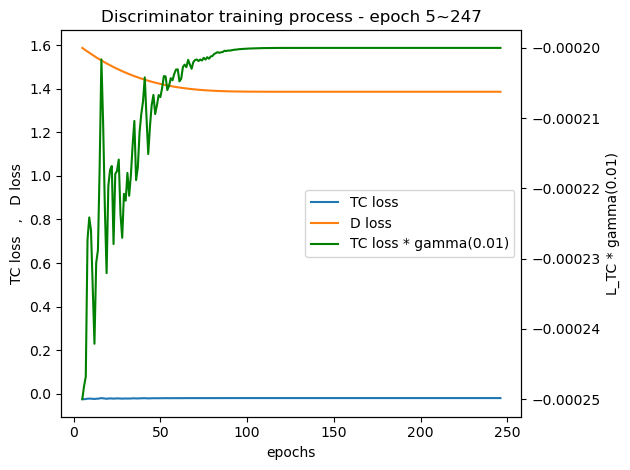

In [18]:
## 'TC_loss', gamma=1
## 'discriminator_loss'

## ---------------------------------------------------------------
left = 5
right = len(epochs)

fig, ax1 = plt.subplots()
lns1 = ax1.plot(epochs[left:right], np.array(train_history["TC_loss"])[left:right], label='TC loss')
lns2 = ax1.plot(epochs[left:right], np.array(train_history["discriminator_loss"])[left:right], label='D loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel(f'TC loss   ,   D loss')

ax2 = ax1.twinx()
lns3 = ax2.plot(epochs[left:right], gamma * np.array(train_history["TC_loss"])[left:right], label=f'TC loss * gamma({gamma})', color='g')
ax2.set_ylabel(f'L_TC * gamma({gamma})')

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.title(f'Discriminator training process - epoch {left}~{right}')
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

fig.tight_layout()
plt.savefig("./teams/disc.png")
plt.show()

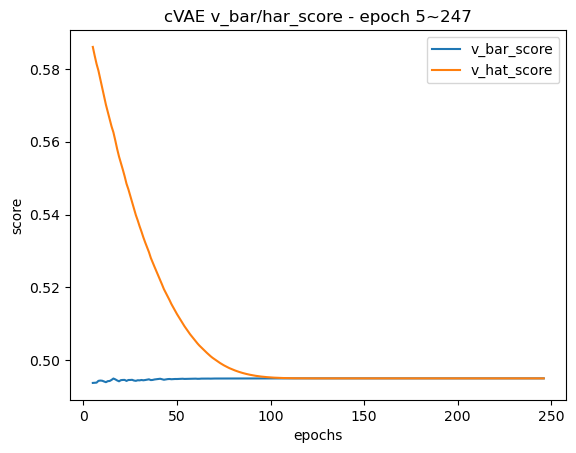

In [19]:
v_bar_score = np.exp(np.array(train_history["TC_loss"])) / (1 + np.exp(np.array(train_history["TC_loss"])))
v_hat_score = 1 - ( np.exp(-1 * np.array(train_history["discriminator_loss"])) / v_bar_score ) 

## ---------------------------------------------------------------
v_bar_score = np.exp(np.array(train_history["TC_loss"])) / (1 + np.exp(np.array(train_history["TC_loss"])))
v_hat_score = 1 - ( np.exp(-1 * np.array(train_history["discriminator_loss"])) / v_bar_score ) 

## ---------------------------------------------------------------
left = 5
right = len(epochs)

plt.plot(epochs[left:right], v_bar_score[left:right], label=f'v_bar_score')
plt.plot(epochs[left:right], v_hat_score[left:right], label=f'v_hat_score')

plt.title(f'cVAE v_bar/har_score - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()

fig.tight_layout()
plt.show()

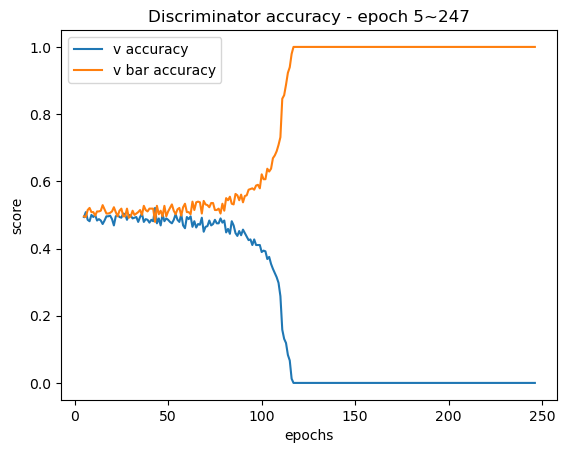

In [20]:
v_bar_score = np.exp(np.array(train_history["TC_loss"])) / (1 + np.exp(np.array(train_history["TC_loss"])))
v_hat_score = 1 - ( np.exp(-1 * np.array(train_history["discriminator_loss"])) / v_bar_score ) 

## ---------------------------------------------------------------
left = 5
right = len(epochs)

plt.plot(epochs[left:right], train_history["v_acc"][left:right], label=f'v accuracy')
plt.plot(epochs[left:right], train_history["v_bar_acc"][left:right], label=f'v bar accuracy')

plt.title(f'Discriminator accuracy - epoch {left}~{right}')
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()

fig.tight_layout()
plt.show()

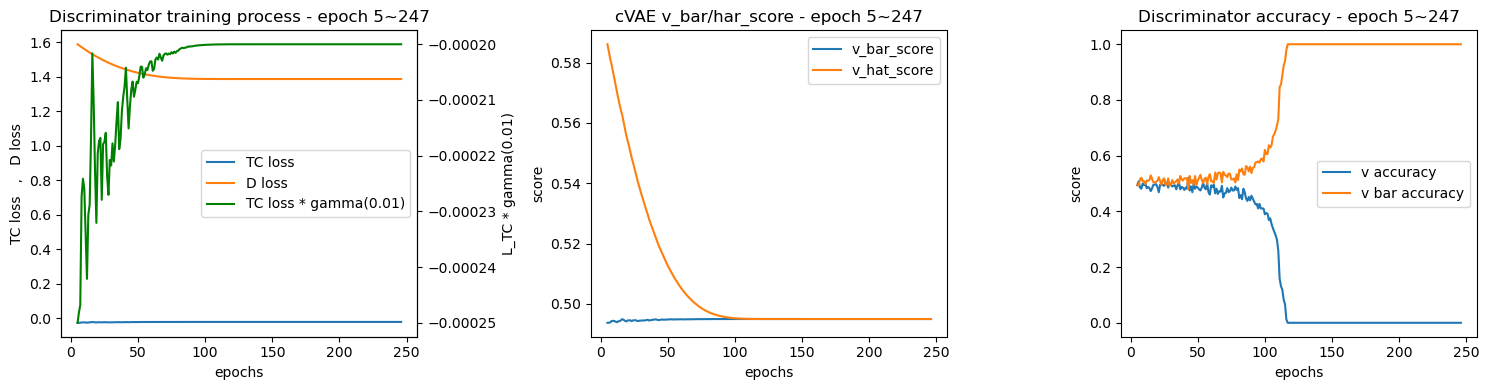

In [21]:
left = 5
right = len(epochs)

fig, (ax1, ax3, ax4) = plt.subplots(1,3,figsize=(15,4))

## tc / D loss
lns1 = ax1.plot(epochs[left:right], np.array(train_history["TC_loss"])[left:right], label='TC loss')
lns2 = ax1.plot(epochs[left:right], np.array(train_history["discriminator_loss"])[left:right], label='D loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel(f'TC loss   ,   D loss')

ax2 = ax1.twinx()
lns3 = ax2.plot(epochs[left:right], gamma * np.array(train_history["TC_loss"])[left:right], label=f'TC loss * gamma({gamma})', color='g')
ax2.set_ylabel(f'L_TC * gamma({gamma})')

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

ax1.set_title(f'Discriminator training process - epoch {left}~{right}')
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

## v / v_bar score
ax3.plot(epochs[left:right], v_bar_score[left:right], label=f'v_bar_score')
ax3.plot(epochs[left:right], v_hat_score[left:right], label=f'v_hat_score')

ax3.set_title(f'cVAE v_bar/har_score - epoch {left}~{right}')
ax3.set_xlabel("epochs")
ax3.set_ylabel("score")
ax3.legend()

## acc
left = 5
right = len(epochs)

ax4.plot(epochs[left:right], train_history["v_acc"][left:right], label=f'v accuracy')
ax4.plot(epochs[left:right], train_history["v_bar_acc"][left:right], label=f'v bar accuracy')

ax4.set_title(f'Discriminator accuracy - epoch {left}~{right}')
ax4.set_xlabel("epochs")
ax4.set_ylabel("score")
ax4.legend()

##
fig.tight_layout()
plt.savefig("./teams/disc.png")
plt.show()

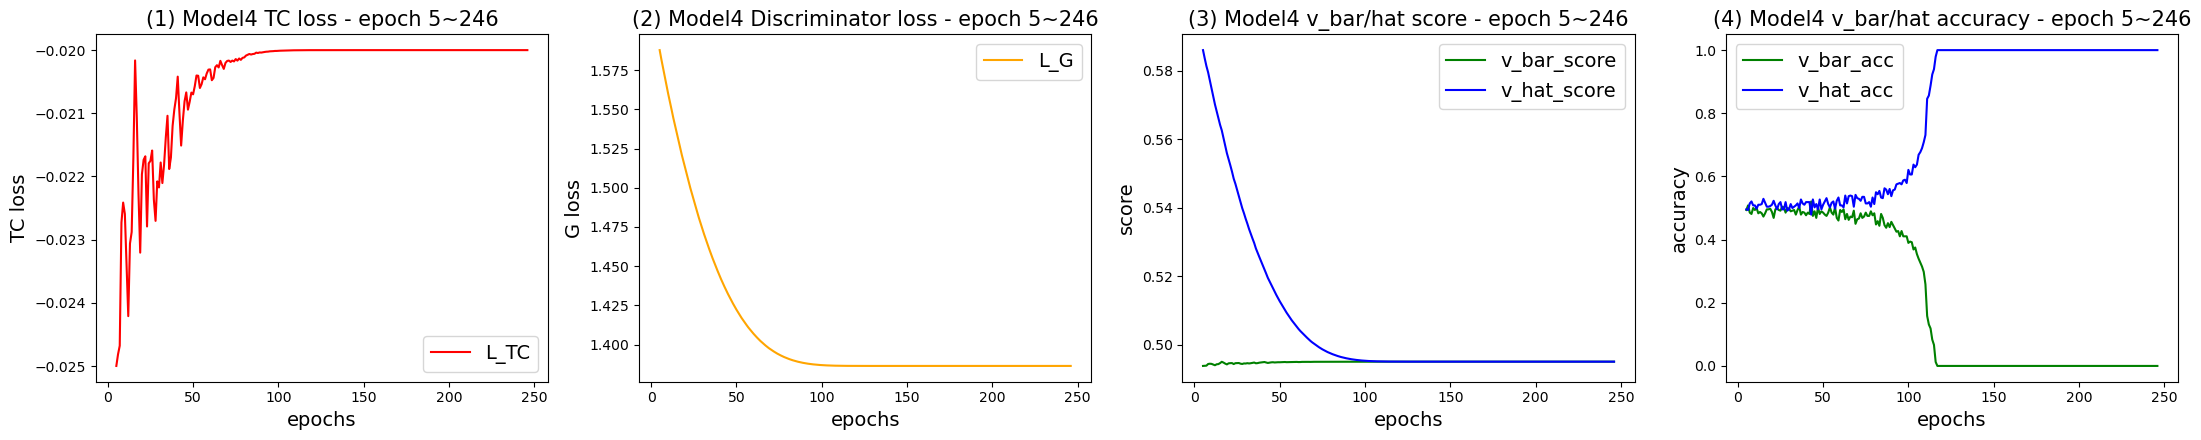

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(22, 4.5))
title_size = 15
label_size = 14
legend_size = 14

## tc loss
left = 5
right = len(epochs)
ax1.plot(epochs[left:right], np.array(train_history["TC_loss"])[left:right], label='L_TC', color='red')
ax1.set_xlabel('epochs', fontsize=label_size)
ax1.set_ylabel(f'TC loss', fontsize=label_size)
ax1.legend(fontsize=legend_size)
ax1.set_title(f'(1) Model4 TC loss - epoch {left}~{right-1}', fontsize=title_size)

## G loss
left = 5
right = len(epochs)
ax2.plot(epochs[left:right], np.array(train_history["discriminator_loss"])[left:right], label='L_G', color='orange')
ax2.set_xlabel('epochs', fontsize=label_size)
ax2.set_ylabel(f'G loss', fontsize=label_size)
ax2.legend(fontsize=legend_size)
ax2.set_title(f'(2) Model4 Discriminator loss - epoch {left}~{right-1}', fontsize=title_size)

## v / v_bar score
left = 5
right = len(epochs)
ax3.plot(epochs[left:right], v_bar_score[left:right], label=f'v_bar_score', color='green')
ax3.plot(epochs[left:right], v_hat_score[left:right], label=f'v_hat_score', color='blue')
ax3.set_title(f'(3) Model4 v_bar/hat score - epoch {left}~{right-1}', fontsize=title_size)
ax3.set_xlabel("epochs", fontsize=label_size)
ax3.set_ylabel("score", fontsize=label_size)
ax3.legend(fontsize=legend_size)

## acc
left = 5
right = len(epochs)
ax4.plot(epochs[left:right], train_history["v_acc"][left:right], label=f'v_bar_acc', color='green')
ax4.plot(epochs[left:right], train_history["v_bar_acc"][left:right], label=f'v_hat_acc', color='blue')
ax4.set_title(f'(4) Model4 v_bar/hat accuracy - epoch {left}~{right-1}', fontsize=title_size)
ax4.set_xlabel("epochs", fontsize=label_size)
ax4.set_ylabel("accuracy", fontsize=label_size)
ax4.legend(fontsize=legend_size)

##
fig.tight_layout()
plt.savefig("./analysis/Model4-G.png")
plt.show()